# Evaluation Notebook 
---

We can now move on to evaluation of the model. The recorded metrics looked quite good during training with F1, recall, and precision scores being comparable to previous runs. Overall, this would seem to indicate that model performance has not been negatively impacted by changes to the preprocessing code. Due to the nature of this prediction task, however, a purely quantitative analysis based on metrics like recall or precision isn't sufficient. What ultimately matters is the quality of the predicted tags, which requires a bit of human judgement. 

In this notebook we will actually examine the predicted tags on the evaluation dataset as well as tag the same test file as was previously tagged for quality assurance (see `Tag_DE_test_csv.ipynb`). This will allow us to make a qualitative comparison to the previous model. 

This evaluation procudure highlights one of the main difficulties in productionizing this particular model. We need to be able to find ways to automate parts of this evaluation process so that we can effectively monitor the model's performance in production. This will be need to be a key area of focus after the creation of the training pipeline. Unfortunately, it may simply be the case that some degree of human evaluation is still required at periodic intervals in order to gauge the performance of the model. 

The notebook is structured as follows: 

    A. Examining Predictions on the Eval Set
    B. Tagging a test set of ~80 Examples 

In [1]:
import json
import tempfile
import pprint
import os
import tensorflow as tf
import tfx
import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils
from sklearn.model_selection import train_test_split
import apache_beam as beam
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K


from matplotlib import pyplot as plt

import re

import pandas as pd
import numpy as np

from google.cloud import storage
import pickle

In [2]:
# Output of the preprocessing
TRANSFORM_DIR = 'gs://ml-sandbox-tagging-tfx-experiments/preprocessing_notebook'
TRANSFORMED_TRAIN = 'train_transformed'
TRANSFORMED_TEST = 'test_transformed'
LABEL_FILE_NAME = 'tags'
VOCAB_FILE_NAME = 'vocab'

**NOTE:** These metrics were copied from the original training notebooks for fair model comparsions in case they different from the keras metrics. In the future, we will probably just use the [standard metrics from Keras](https://www.tensorflow.org/api_docs/python/tf/keras/metrics). 

In [3]:
def recall_score(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_score(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    def recall_score(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_score(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



**NOTE:** This was copied from the training notebook. In the future, we would not need to repeat this code here when using TFX. 

In [4]:
tf_transform_output = tft.TFTransformOutput(TRANSFORM_DIR)

tag_file = tf_transform_output.vocabulary_file_by_name(LABEL_FILE_NAME)
tags_df = pd.read_csv(tag_file, header=None)
NUM_TAGS = len(tags_df)

vocab_file = tf_transform_output.vocabulary_file_by_name(VOCAB_FILE_NAME)
vocab_df = pd.read_csv(vocab_file, header=None)
VOCAB_SIZE = len(vocab_df)

MAX_STRING_LENGTH = 277

def create_tag_lookup_table():
    table = tf.lookup.StaticVocabularyTable(
        tf.lookup.TextFileInitializer(
            tag_file,
            key_dtype=tf.string, key_index=tf.lookup.TextFileIndex.WHOLE_LINE,
            value_dtype=tf.int64, value_index=tf.lookup.TextFileIndex.LINE_NUMBER,
            delimiter=None),
        num_oov_buckets=1)
    return table

table = create_tag_lookup_table()

def label_transform(x, y):
    """Use the number of classes to convert the sparse tag indicies to dense"""
    # Need to add one for out-of-vocabulary tags in eval dataset
    return (x, tf.cast(tf.sparse.to_indicator(table.lookup(y), vocab_size=NUM_TAGS + 1), tf.int32))

def _input_fn(file_pattern, tf_transform_output, batch_size=64, shuffle=True, epochs=None):
    """Generates features and label for tuning/training.
    Args:
        file_pattern: input tfrecord file pattern.
        tf_transform_output: A TFTransformOutput.
        batch_size: representing the number of consecutive elements of
          returned dataset to combine in a single batch
    Returns:
        A dataset that contains (features, indices) tuple where features
        is a dictionary of Tensors, and indices is a single Tensor of
        label indices.
    """
    transformed_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy()
    )

    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transformed_feature_spec,
        reader=tf.data.TFRecordDataset,
        shuffle=shuffle,
        label_key='series_ep_tags',
        num_epochs=epochs
    )
    return dataset.map(label_transform)

In [5]:
model = load_model('gs://ml-sandbox-tagging-tfx-experiments/models/1/',
                   custom_objects={'precision_score': precision_score,
                                   'recall_score': recall_score,
                                   'f1': f1})

In [6]:
history = pd.read_csv('gs://ml-sandbox-tagging-tfx-experiments/models/training_statistics.csv', 
                     index_col=0)

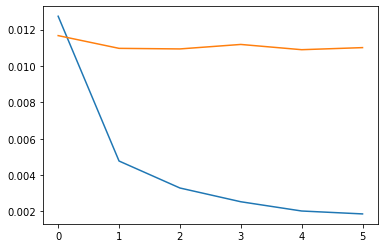

In [7]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

Training curves honestly look pretty bad. Model is not generalizing to the eval dataset. May need to try another model or rethink the approach. 

In [8]:
display(history)

,loss,precision_score,recall_score,f1,val_loss,val_precision_score,val_recall_score,val_f1,lr
0,0.012735,0.771525,0.393911,0.490293,0.011670,0.660315,0.369182,0.466203,0.00050
1,0.004773,0.908104,0.682437,0.773890,0.010969,0.685465,0.431948,0.524783,0.00050
2,0.003289,0.936991,0.781907,0.849892,0.010937,0.681690,0.459060,0.544093,0.00050
3,0.002533,0.950384,0.831648,0.885395,0.011184,0.687577,0.471237,0.554293,0.00050
4,0.002023,0.961353,0.860864,0.906991,0.010895,0.706737,0.484603,0.570167,0.00005
5,0.001863,0.964994,0.870738,0.914312,0.011009,0.704529,0.485291,0.569727,0.00005


Precision is slightly lower than previous model, but recall is higher and overall f1 score is higher. 

In the original training notebook, "thresholds" on the validation metrics were defined: 0.7 for precision, 0.4 for recall, and 0.5 for f1. Even though these thresholds were perhaps a bit arbitrary, it is certainly promising that we were able to hit these thresholds during the training. 

---
---

### **A. Examining Predictions on the Evaluation Set**

Though the loss curves from training look quite bad, the quantitative performance ultimately might not matter so much. Let's take look at the decoded predictions on the evaluation set, this should give us a better indication of what is going on. 

In [9]:
# Shuffle is true so we can look at random examples
eval_dataset = _input_fn(
    file_pattern=os.path.join(TRANSFORM_DIR, TRANSFORMED_TEST + '*'),
    tf_transform_output=tf_transform_output,
    batch_size=1,
    epochs=1,
    shuffle=True
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
# Add in empty string so we can easily decode the inputs
vocab_df.loc[len(vocab_df)] = ''
tags_df.loc[len(tags_df)] = ''

def decode_features(features):
    feat_array = features['features'].numpy().reshape(-1,)
    words = vocab_df.iloc[feat_array].values
    synopsis = (' ').join(np.hstack(words))
    
    return synopsis

def decode_true_tags(tags):
    tag_idx = np.argwhere(tags == 1)[:, 1]
    decoded_tags = np.hstack(tags_df.iloc[tag_idx].values)
    
    return decoded_tags

def decode_predictions(predictions, top_n=10, thresh=None):
    sorted_predicted_tags = np.argsort(predictions, axis=1)[:, ::-1][0]
    
    decoded_predictions = np.hstack(tags_df.iloc[sorted_predicted_tags].values)
    prediction_frame = pd.DataFrame(zip(decoded_predictions, 
                                        predictions[0][sorted_predicted_tags]), 
                                    columns=['Predicted Tag', 'Probability'])
    prediction_frame['Probability'] = prediction_frame['Probability'].round(2)
    
    if top_n:
        prediction_frame = prediction_frame.iloc[:top_n]
        
    if thresh:
        prediction_frame = prediction_frame.loc[prediction_frame['Probability'] > thresh]
        
    return prediction_frame

**NOTE:** Eval dataset is shuffled, **rerun this cell** to look at different random samples! 

In [21]:
for features, tags in eval_dataset.take(1):
    decoded_features = decode_features(features)
    decoded_tags = decode_true_tags(tags)
    decoded_tags = pd.DataFrame(decoded_tags, columns=['True Tags'])
    
    predictions = model.predict(features)
    decoded_predictions = decode_predictions(predictions, top_n=len(decoded_tags))

    
    print('{:=^80}'.format(' Synopsis '))
    print(decoded_features)
    print('{:=^80}'.format(' Tags '))
    display(decoded_tags)
    print('{:=^80}'.format(' Predicted Tags '))
    display(decoded_predictions)

=================================== Synopsis ===================================
die prinzessin glaubt einen geist gesehen zu haben und die paw patrol muss in quot mission paw royally  quot auf den grund gehen in quot pups save monkey  quot stiehlt bürgermeister  eine magische maske  wetter luftschiff wird von bürgermeister  gestohlen ein herd explodiert bei einem chili koch off und bürgermeister   scheint bereit zu sein die katzenausstellung von adventure bay zu gewinnen ein team von welpen angeführt vom energiegeladenen ryder ist immer bereit wenn es geht darum in der adventure bay zu helfen paw patrol ist in bewegung cartoons under paw patrol                                                                                                                                                                                   
===================================== Tags =====================================


,True Tags
0,kids_cartoon
1,under 5
2,kids_adventure
3,kids_comedy
4,kids_animal
5,kids_friendship
6,kids_cgi_animation
7,kids_dogs


================================ Predicted Tags ================================


,Predicted Tag,Probability
0,under 5,1.00
1,kids_cartoon,1.00
2,kids_adventure,0.99
3,kids_seas_&_oceans,0.29
4,kids_education,0.25
5,kids_animal,0.19
6,kids_cgi_animation,0.16
7,kids_gaelic_language,0.05


For the most part, the predicted tags actually look quite good! The probabilities seem to be quite reasonable as well. 

Interestingly, there are some cases where some of the predicted tags makes sense but are not in the set of true tags. This is a pretty good sign! 

---
---

### **B. Tagging A Test Set**

We will now tag a test file sent over by DE product. This is the same set of examples that was tested with the previous iteration of the model. 

One important thing this test might help illuminate is how much predictions vary across different models. We would hope that the predictions are quite stable...

**NOTE:** We are doing the tagging quite "manually" here. In the future, we'd probably want to handle this with the [TFX bulk inferrer](https://www.tensorflow.org/tfx/guide/bulkinferrer) component. This could come at the end of the training pipeline or could be leveraged as part of a separate evaluation pipeline. 

**NOTE:** We are also doing the pre-preprocessing quite manually. Hopefully we can avoid this in the future by incorporating these steps into the `preprocessing_fn` somehow. This will require some coordination to uncover the various formats we might see the data. 

We will tag the test set using the `saved_model_cli`. This will also allow us to see whether we can actually serve the model. 

In [26]:
test_df = pd.read_csv("gs://ml-sandbox-101-tagging/data/raw/DE_Content_autotagging_syntax_test.csv", index_col=0)

test_df['clean_title'] = test_df.title.apply(lambda x: re.sub(r's\de\d',"",x.lower()).split(':')[0].strip())
test_df['title_word'] = test_df.clean_title.apply(lambda x: x.strip().replace(' ','_'))

test_df['combi'] = test_df.fillna("")[['genre','subgenres','synopsis']].apply(lambda row: " ".join(row), axis=1)

temp = test_df.groupby('clean_title')['combi'].apply(" ".join).to_frame().reset_index()
temp = temp.rename(columns={'combi':'group_combi'})

test_df = pd.merge(test_df,temp,on='clean_title',how='left')

In [27]:
test_df.head()

,typ,uuid,title,genre,subgenres,synopsis,tags,notes,clean_title,title_word,combi,group_combi
0,FTA,5654bc76-cdfb-4de4-8282-3c0dc4c0002f,Der Bachelor,NaN,NaN,Aus lizenzvertraglichen Gründen Programminfos ...,no_synopsis,NaN,der bachelor,der_bachelor,Aus lizenzvertraglichen Gründen Programminfo...,Aus lizenzvertraglichen Gründen Programminfo...
1,FTA,a74d9bda-19cf-4d58-81a6-2cd80dc187b7,Deutschland sucht den Superstar,NaN,NaN,Aus lizenzvertraglichen Gründen Programminfos ...,no_synopsis,NaN,deutschland sucht den superstar,deutschland_sucht_den_superstar,Aus lizenzvertraglichen Gründen Programminfo...,Aus lizenzvertraglichen Gründen Programminfo...
2,FTA,dd59b73b-ff26-4e85-9d58-4410abf5cdca,Volle Kanne,NaN,NaN,Das ZDF-Magazin präsentiert prominente Gäste u...,"['factual', 'news', 'asia', 'magazine', 'japan...",NaN,volle kanne,volle_kanne,Das ZDF-Magazin präsentiert prominente Gäste...,Das ZDF-Magazin präsentiert prominente Gäste...
3,FTA,0ae37637-5b48-402e-ae35-bd717ce7b142,Tagesschau,NaN,NaN,"Aktuelle Themen aus Politik, Wirtschaft, Kultu...","['news', 'politics', 'affairs', 'europe', 'cur...",NaN,tagesschau,tagesschau,"Aktuelle Themen aus Politik, Wirtschaft, Kul...","Aktuelle Themen aus Politik, Wirtschaft, Kul..."
4,FTA,b6fe2170-112f-47c8-b134-a809ef675a7c,Kollaps,NaN,NaN,Noteinsatz auf einem Dortmunder Kinderspielpla...,"['united kingdom', 'crime', 'family & relation...",NaN,kollaps,kollaps,Noteinsatz auf einem Dortmunder Kinderspielp...,Noteinsatz auf einem Dortmunder Kinderspielp...


In [30]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(feature):
    input_example = {
          'features': _bytes_feature(feature)
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=input_example))
    return example_proto.SerializeToString()

In [31]:
input_features = test_df['group_combi'].values
utf_encoded = np.array([feature.encode('utf-8') for feature in input_features])
all_examples = [serialize_example(encoded) for encoded in utf_encoded]

In [35]:
with open("test_examples.pkl", "wb") as test_file:
    pickle.dump(all_examples, test_file)

In [37]:
%%bash
saved_model_cli run \
    --dir gs://ml-sandbox-tagging-tfx-experiments/models/2 \
    --tag_set serve \
    --signature_def serving_default \
    --inputs "examples=test_examples.pkl" \
    --outdir "./" \
    --overwrite

Result for output key outputs:
[[9.7040653e-02 1.2519845e-01 2.2040218e-01 ... 3.1982750e-02
  3.1826735e-02 2.5292307e-02]
 [9.7040653e-02 1.2519845e-01 2.2040218e-01 ... 3.1982750e-02
  3.1826735e-02 2.5292307e-02]
 [1.6833663e-02 4.6759248e-03 3.4187800e-01 ... 5.5816770e-04
  8.0388784e-04 3.1393766e-04]
 ...
 [3.2249856e-01 8.9828765e-01 1.4528275e-02 ... 1.6888976e-04
  2.0951033e-04 2.3210049e-04]
 [1.5592822e-01 1.3899651e-01 2.8662527e-01 ... 5.5059791e-03
  7.0389509e-03 5.8575869e-03]
 [3.5311550e-02 4.2110473e-02 2.6585698e-01 ... 2.6392937e-04
  7.2839856e-04 4.2319298e-04]]
Output outputs is saved to ./outputs.npy


2020-10-15 07:19:31.660009: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2020-10-15 07:19:31.660057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-10-15 07:19:33.842151: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-15 07:19:33.855924: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-15 07:19:33.855995: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thomas-training): /proc/driver/nvidia/version does not exist
2020-10

In [38]:
predictions = np.load('outputs.npy')

In [41]:
print(predictions)
print(predictions.shape)
print(len(test_df))

[[9.7040653e-02 1.2519845e-01 2.2040218e-01 ... 3.1982750e-02
  3.1826735e-02 2.5292307e-02]
 [9.7040653e-02 1.2519845e-01 2.2040218e-01 ... 3.1982750e-02
  3.1826735e-02 2.5292307e-02]
 [1.6833663e-02 4.6759248e-03 3.4187800e-01 ... 5.5816770e-04
  8.0388784e-04 3.1393766e-04]
 ...
 [3.2249856e-01 8.9828765e-01 1.4528275e-02 ... 1.6888976e-04
  2.0951033e-04 2.3210049e-04]
 [1.5592822e-01 1.3899651e-01 2.8662527e-01 ... 5.5059791e-03
  7.0389509e-03 5.8575869e-03]
 [3.5311550e-02 4.2110473e-02 2.6585698e-01 ... 2.6392937e-04
  7.2839856e-04 4.2319298e-04]]
(89, 2597)
89


We were able to get predictions for the entire test set! Now to see if the predictions actually make sense...

In [42]:
sorted_predicted_tags = np.argsort(predictions, axis=1)[:, ::-1]

In [59]:
results = []
probs = []

tags_to_keep = 10

for i, prediction in enumerate(predictions):
    if test_df.tags.values[i] == 'no_synopsis':
        results.append('no_synopsis')
        probs.append('N/A')
    else: 
        top_tags = np.hstack(tags_df.iloc[sorted_predicted_tags[i]].values[:tags_to_keep])
        results.append(list(top_tags))

        confidences = prediction[sorted_predicted_tags[i]][:tags_to_keep]
        probs.append(confidences)

In [61]:
previous_tag = pd.read_csv("gs://ml-sandbox-101-tagging/data/raw/DE_Content_autotagging_syntax_test_tagged.csv", 
                           index_col=0)

In [63]:
previous_tag.head()

,typ,uuid,title,genre,subgenres,synopsis,tags,notes,clean_title,title_word,combi,group_combi,new_tags,confidence
0,FTA,5654bc76-cdfb-4de4-8282-3c0dc4c0002f,Der Bachelor,NaN,NaN,Aus lizenzvertraglichen Gründen Programminfos ...,no_synopsis,NaN,der bachelor,der_bachelor,Aus lizenzvertraglichen Gründen Programminfo...,lizenzvertraglichen gründen programminfos verf...,no_synopsis,Low
1,FTA,a74d9bda-19cf-4d58-81a6-2cd80dc187b7,Deutschland sucht den Superstar,NaN,NaN,Aus lizenzvertraglichen Gründen Programminfos ...,no_synopsis,NaN,deutschland sucht den superstar,deutschland_sucht_den_superstar,Aus lizenzvertraglichen Gründen Programminfo...,lizenzvertraglichen gründen programminfos verf...,no_synopsis,Low
2,FTA,dd59b73b-ff26-4e85-9d58-4410abf5cdca,Volle Kanne,NaN,NaN,Das ZDF-Magazin präsentiert prominente Gäste u...,"['factual', 'news', 'asia', 'magazine', 'japan...",NaN,volle kanne,volle_kanne,Das ZDF-Magazin präsentiert prominente Gäste...,magazin präsentieren prominente gäste service ...,"['food & cooking', 'factual', 'tips & advice',...",1H9L
3,FTA,0ae37637-5b48-402e-ae35-bd717ce7b142,Tagesschau,NaN,NaN,"Aktuelle Themen aus Politik, Wirtschaft, Kultu...","['news', 'politics', 'affairs', 'europe', 'cur...",NaN,tagesschau,tagesschau,"Aktuelle Themen aus Politik, Wirtschaft, Kul...",aktuell themen politik wirtschaft kultur sport...,"['documentary', 'society', 'europe', 'factual'...",5H5L
4,FTA,b6fe2170-112f-47c8-b134-a809ef675a7c,Kollaps,NaN,NaN,Noteinsatz auf einem Dortmunder Kinderspielpla...,"['united kingdom', 'crime', 'family & relation...",NaN,kollaps,kollaps,Noteinsatz auf einem Dortmunder Kinderspielp...,noteinsatz dortmunder kinderspielplatz sechsjä...,"['documentary', 'family & relationship', 'pare...",4H6L


In [64]:
previous_tag['predicted_tags_new_model'] = results
previous_tag['confidence_new_model'] = probs

In [65]:
display(previous_tag[['new_tags', 'confidence', 'predicted_tags_new_model', 'confidence_new_model']])

,new_tags,confidence,predicted_tags_new_model,confidence_new_model
0,no_synopsis,Low,no_synopsis,N/A
1,no_synopsis,Low,no_synopsis,N/A
2,"['food & cooking', 'factual', 'tips & advice',...",1H9L,"[competition, tips & advice, game show, fashio...","[0.53762394, 0.39052236, 0.38325572, 0.3472697..."
3,"['documentary', 'society', 'europe', 'factual'...",5H5L,"[politics, society, news, factual, history, th...","[0.8382405, 0.77600294, 0.47971675, 0.4418002,..."
4,"['documentary', 'family & relationship', 'pare...",4H6L,"[work life balance, family & relationship, dom...","[0.39917642, 0.39805096, 0.39259452, 0.3304067..."
...,...,...,...,...
84,"['sci-fi', 'thriller', 'action', 'imaginative'...",6H4L,"[thriller, action, sci-fi, imaginative, tense,...","[0.68279994, 0.5923272, 0.58054745, 0.5728739,..."
85,"['thriller', 'action', 'espionage & spying', '...",2H8L,"[thriller, crime, drama, action, mystery, murd...","[0.9380072, 0.7798225, 0.658823, 0.6076958, 0...."
86,"['thriller', 'mystery', 'crime', 'dark', 'murd...",High,"[thriller, drama, crime, tense, murder, psycho...","[0.90553546, 0.89828765, 0.82583225, 0.7653932..."
87,"['adult', 'exclude_from_recs', 'lust & desires...",3H7L,"[dating & relationship, factual, united kingdo...","[0.4641252, 0.28662527, 0.26620573, 0.26237163..."


In [99]:
from ipywidgets import interact, fixed

In [108]:
def display_old_new_tags(df, idx):
    synopsis = df.iloc[idx]['group_combi']
    old_probs = df.iloc[idx]['confidence']
    
    try:
        old_tags = eval(df.iloc[idx]['new_tags'])
    except:
        old_tags = df.iloc[idx]['new_tags']
    new_tags = df.iloc[idx]['predicted_tags_new_model']
    confidence_new_model = df.iloc[idx]['confidence_new_model']
    
    comparison_frame = pd.DataFrame(np.vstack((old_tags, new_tags, confidence_new_model)).T, 
                        columns=['Tags Old Model', 'Tags New Model', 'Probs New Model'])
    
    print('{:=^80}'.format(' Synopsis '))
    print(synopsis)
    print('{:=^80}'.format(' Model Comparison '))
    print("OLD PROBS: ", old_probs)
    display(comparison_frame)

In [109]:
interact(display_old_new_tags, df=fixed(previous_tag), idx=range(len(previous_tag)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.display_old_new_tags(df, idx)>